In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [217]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [165]:
df = pd.read_csv('data.csv', encoding='utf-8-sig', index_col=0)

In [166]:
print(df.dtypes)
df.describe()

region            int64
education         int64
jobtype           int64
cptype            int64
sales           float64
employees       float64
aversalary      float64
capital         float64
pros_encoded    float64
dtype: object


,region,education,jobtype,cptype,sales,employees,aversalary,capital,pros_encoded
count,3014.000000,3014.000000,3014.000000,3014.000000,2252.000000,2481.000000,2149.000000,2302.000000,3014.000000
mean,0.764764,0.835766,0.482747,0.669874,2.887766,1.113145,0.154087,22.411547,0.152853
std,0.809055,1.170739,0.499785,0.816874,7.978654,3.166932,0.750271,105.102728,0.609940
min,0.000000,0.000000,0.000000,0.000000,-0.130200,-0.209200,-1.782600,-0.113000,-0.500000
25%,0.000000,0.000000,0.000000,0.000000,-0.125250,-0.187600,-0.304300,-0.106575,-0.350000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,1.000000,1.000000,0.874800,0.802500,0.695700,0.893500,0.650000
max,2.000000,5.000000,1.000000,2.000000,95.856900,24.790700,2.391300,605.986800,2.800000


In [167]:
print("0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주")
print("1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산")
print("2 -> 수도권 : 서울, 인천, 세종, 경기")
print()

region_counts = df['region'].value_counts()

total = df['region'].value_counts().sum()
for region, counts in enumerate(region_counts):
    print(f"{region} -> {counts} ({np.round(counts/total, 4)})")

0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주
1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산
2 -> 수도권 : 서울, 인천, 세종, 경기

0 -> 1424 (0.4725)
1 -> 875 (0.2903)
2 -> 715 (0.2372)


### 상관계수 및 VIF 확인 & 가중치 감쇠를 통한 feature selection 시도 (불균형 데이터셋)

<h5> Sales-Employees, Sales-capital 사이 (+) 상관관계가 유의미하다고 도출 </h5>

Columns:  ['region' 'education' 'jobtype' 'cptype' 'sales' 'employees' 'aversalary'
 'capital' 'pros_encoded']
class  0
[ 0.00875164 -0.21195054 -0.11670908  0.01277451 -0.080416   -0.02119596
 -0.00218514 -0.04768187]
class  1
[ 0.08007781  0.01728407 -0.25462986  0.04460912 -0.00445151 -0.07513346
 -0.00983888 -0.44143321]
class  2
[-0.08882945  0.19466647  0.37133894 -0.05738362  0.08486751  0.09632942
  0.01202402  0.48911508]
Mean accuracy (train set) :  0.5193
Mean accuracy (test set) :  0.4471


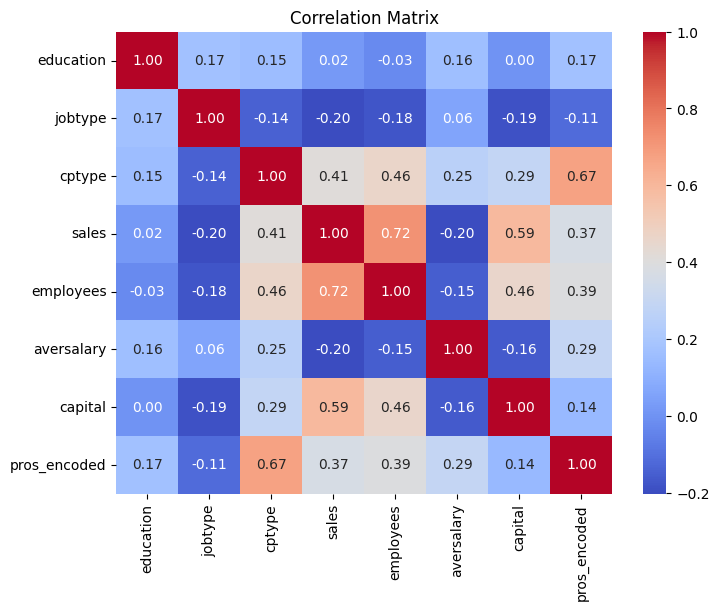

1.7039
1.6099
3.1158
4.0994
3.8746
1.5842
2.4201
2.2464


In [168]:
# NaN 처리
df_dropna = df.dropna()
X = df_dropna.iloc[:, 1:]
y = df_dropna['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747, stratify=y)

# Lasso classifier
# C is inverse of alpha
linear = LogisticRegression(penalty='l2', C=10)
linear.fit(X_train, y_train)

# feature selection -> sales, employees, capital
print("Columns: ", df.columns.values)
for i in range(len(linear.coef_)):
    print("class ", i)
    coef_set = linear.coef_[i]
    print(coef_set)

# Prediction accuracy
print("Mean accuracy (train set) : ", np.round(linear.score(X_train, y_train), 4))
print("Mean accuracy (test set) : ", np.round(linear.score(X_test, y_test), 4))

# Correlation matrix
correlation_matrix = df.loc[:, 'education': 'pros_encoded'].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

for feature in range(len(df.columns[1:])):
    print(np.round(variance_inflation_factor(X_train, feature), 4))

### Undersampling 을 적용하여 동일한 과정 반복  
=> 일반화 성능은 올라갔고, test score 는 거의 변동없음  
=> 그 외 VIF, 상관계수도 거의 변동없음

Index(['region', 'education', 'jobtype', 'cptype', 'sales', 'employees',
       'aversalary', 'capital', 'pros_encoded'],
      dtype='object')
[-0.0205228  -0.22401194 -0.04327763 -0.00574024 -0.11440587 -0.06901762
  0.00110553  0.14817471]
[ 0.04996048  0.01752282 -0.27739579  0.0417619   0.0333319  -0.07661775
 -0.01044453 -0.44697068]
[-0.02943768  0.20648911  0.32067342 -0.03602166  0.08107397  0.14563538
  0.009339    0.29879597]
Mean accuracy (train set) :  0.476
Mean accuracy (test set) :  0.4583


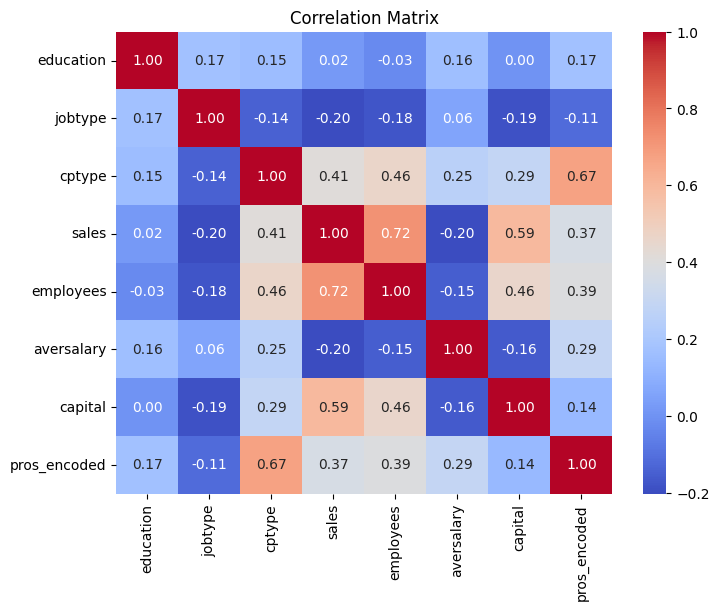

1.686
1.6506
3.0643
3.5572
3.6246
1.5366
2.4263
2.2622


In [169]:
# NaN 처리
df_dropna = df.dropna()

class_0_sample = df_dropna[df_dropna['region'] == 0].sample(n=400, replace=False)
class_1_sample = df_dropna[df_dropna['region'] == 1].sample(n=400, replace=False)
class_2_sample = df_dropna[df_dropna['region'] == 2].sample(n=400, replace=False)

df_balanced = pd.concat([class_0_sample, class_1_sample, class_2_sample])

df_balanced.reset_index(drop=True, inplace=True)

X = df_balanced.iloc[:, 1:]
y = df_balanced['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747, stratify=y)

# Lasso classifier
# C is inverse of alpha
linear = LogisticRegression(penalty='l2', C=10)
linear.fit(X_train, y_train)

# feature selection -> sales, employees, capital
print(df.columns)
for coef_set in linear.coef_:
    print(coef_set)

print("Mean accuracy (train set) : ", np.round(linear.score(X_train, y_train), 4))
print("Mean accuracy (test set) : ", np.round(linear.score(X_test, y_test), 4))

correlation_matrix = df.loc[:, 'education': 'pros_encoded'].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

for feature in range(len(df.columns[1:])):
    print(np.round(variance_inflation_factor(X_train, feature), 4))

### GradientBoostingClassifier (불균형 데이터셋)

In [170]:
df_dropna = df.dropna()

print(df_dropna['region'].value_counts())

X = df_dropna.iloc[:, 1:]
y = df_dropna['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747)

clf = GradientBoostingClassifier(n_estimators=100,
                                 learning_rate=0.2,
                                 max_depth=1,
                                 random_state=505).fit(X_train, y_train)
print(np.round(clf.score(X_test, y_test), 4))

region
0    780
1    440
2    432
Name: count, dtype: int64
0.4773


### GradientBoostingClassifier (UnderSampling 적용)

In [171]:
df_dropna = df.dropna()
# 클래스 별로 400개씩 무작위로 샘플링
class_0_sample = df_dropna[df_dropna['region'] == 0].sample(n=400, replace=False)
class_1_sample = df_dropna[df_dropna['region'] == 1].sample(n=400, replace=False)
class_2_sample = df_dropna[df_dropna['region'] == 2].sample(n=400, replace=False)

df_balanced = pd.concat([class_0_sample, class_1_sample, class_2_sample])

df_balanced.reset_index(drop=True, inplace=True)

X = df_balanced.iloc[:, 1:]
y = df_balanced['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747)

clf = GradientBoostingClassifier(n_estimators=100,
                                 learning_rate=0.2,
                                 max_depth=1,
                                 random_state=505).fit(X_train, y_train)

print(np.round(clf.score(X_test, y_test), 4))

0.4625


### 중소기업일수록 회사정보가 등록되지 않았을 것(= 결측치로 수집되었을 것)이라고 가정
지금까지 결측치는 전부 drop 처리하고 진행하였다.

 => 가정이 참이라면 결측치를 drop 했을 경우 중소기업에 대한 행 데이터가 다수 빠졌을 것  
 => '기업타입(대기업, 중견, 중소, ...)' 과 '지역'(종속변수) 은 중요한 연관이 있을지도 모른다.  
 => 따라서 결측치를 drop 하면 예측과 분석에 불리해질 수도 있다.  

따라서 앞으로의 과정에는 결측값에 대한 별도 처리가 필요하지 않은 모델인 XgboostClassifier 를 사용해서 결측값을 포함해서 학습시켜 볼 것이다.  
라벨 인코딩 된 피쳐들과 수치형 데이터를 갖는 피쳐들의 스케일을 더 이상 맞추기 힘들다고 판단한 상황에서,  
피처 스케일링이 필요없는 해당 모델을 사용하는 것이 그렇지 않은 모델을 사용하는 것보다 더 알맞다고 생각된다.  

따라서 앞으로의 과정은 다음과 같다.  
<ul>1. 결측값이 존재하는 행에 대해 데이터 탐색 과정을 거치고</ul>
<ul>2. Xgboost 를 통해 결측값을 포함하여 학습 및 예측을 수행</ul>
<ul>3. 결측값을 제외한 채로 Xgboost 를 통해 학습 및 예측 수행</ul>
<ul>4. 1~3 과정을 통해 최선의 데이터셋 (baseline) 을 설정하고 하이퍼 파라미터 튜닝</ul>

In [175]:
# df = pd.read_csv('data.csv', encoding='utf-8-sig', index_col=0)
nan_rows = df.isna().any(axis=1)

df_nan = df[nan_rows]

print(df_nan.describe())

df_nan.head()

            region    education      jobtype       cptype       sales  \
count  1362.000000  1362.000000  1362.000000  1362.000000  600.000000   
mean      0.734949     0.780470     0.464023     0.461821    6.692517   
std       0.781545     1.153011     0.498887     0.769799   12.811688   
min       0.000000     0.000000     0.000000     0.000000   -0.130200   
25%       0.000000     0.000000     0.000000     0.000000   -0.127200   
50%       1.000000     0.000000     0.000000     0.000000    0.000000   
75%       1.000000     1.000000     1.000000     1.000000    5.933400   
max       2.000000     5.000000     1.000000     2.000000   95.856900   

        employees  aversalary    capital  pros_encoded  
count  829.000000  497.000000  650.00000   1362.000000  
mean     1.230340   -0.180477   68.75026     -0.095374  
std      4.171746    0.626951  188.54690      0.536237  
min     -0.209200   -1.521700   -0.11300     -0.500000  
25%     -0.203600   -0.565200   -0.11070     -0.500000  


,region,education,jobtype,cptype,sales,employees,aversalary,capital,pros_encoded
2,2,0,0,0,95.8569,10.7799,0.8261,NaN,0.95
3,2,0,1,1,21.3606,12.3409,NaN,NaN,0.40
6,2,0,1,0,NaN,NaN,NaN,NaN,0.05
7,2,1,1,1,1.3717,0.8855,1.5652,NaN,0.60
13,2,0,1,2,0.3120,-0.0272,NaN,5.8862,1.00


<h5> 대부분의 결측값은 중소기업에 해당함을 확인 </h5>

In [ ]:
print("지역에 따른 결측값 분포: \n", df_nan['region'].value_counts())
print("회사 규모에 따른 결측값 분포: \n", df_nan['cptype'].value_counts())

지역에 따른 결측값 분포: 
 region
0.0    644
1.0    436
2.0    283
Name: count, dtype: int64
회사 규모에 따른 결측값 분포: 
 cptype
0.0    967
2.0    235
1.0    161
Name: count, dtype: int64


### Xgboost classifier


### Imbalanced Dataset (No drop na) :

상관계수 수치상, 'sales' 피쳐는 좋은 피쳐가 아니라고 판단된다.  
따라서 해당값은 제외하고 학습을 진행한 경우와 그렇지 않은 경우를 비교  
=> random_state를 바꿔서 실행 할 때마다 두 경우의 비교우위관계는 달라졌고, 그 때마다 두 점수가 별로 차이나지도 않는다.  
=> 'sales' 값을 제외하지 않고 그냥 그대로 두고 학습 진행하기로 판단.

In [234]:
X = df.iloc[:, 1:]
y = df['region']

accuracies = []

s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=600)

for train_index, test_index in (s_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb = XGBClassifier(n_estimators=300, learning_rate = 0.1, max_depth=3)

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(acc)

print("Mean acc: ", np.mean(accuracies))

0.5157545605306799
0.5257048092868989
0.5124378109452736
0.5306799336650083
0.5415282392026578
Mean acc:  0.5252210707261037


In [237]:
X = df.loc[:, ['education', 'jobtype', 'cptype', 'employees',
       'aversalary', 'capital', 'pros_encoded'],]
y = df['region']

accuracies = []

s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=66)

for train_index, test_index in (s_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb = XGBClassifier(n_estimators=300, learning_rate = 0.1, max_depth=3)

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(acc)

print("Mean acc: ", np.mean(accuracies))

0.5223880597014925
0.5522388059701493
0.538971807628524
0.538971807628524
0.5498338870431894
Mean acc:  0.5404808735943758


### Imbalanced Dataset (drop na) : 결측값을 포함했을 때보다 일반적으로 score 소폭 증가

In [238]:
X = df_dropna.iloc[:, 1:]
y = df_dropna['region']

accuracies = []

s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=66)

for train_index, test_index in (s_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb = XGBClassifier(n_estimators=300, learning_rate = 0.1, max_depth=3)

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(acc)

print("Mean acc: ", np.mean(accuracies))

0.5861027190332326
0.5438066465256798
0.5636363636363636
0.5242424242424243
0.5969696969696969
Mean acc:  0.5629515700814794


### Balanced dataset (undersampling)  
꽤 크게 accuracy 감소

In [239]:
class_0_sample = df[df['region'] == 0].sample(n=400, replace=False)
class_1_sample = df[df['region'] == 1].sample(n=400, replace=False)
class_2_sample = df[df['region'] == 2].sample(n=400, replace=False)

df_balanced = pd.concat([class_0_sample, class_1_sample, class_2_sample])

df_balanced.reset_index(drop=True, inplace=True)

X = df_balanced.iloc[:, 1:]
y = df_balanced['region']

accuracies = []

# no shuffle
s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=600)

for train_index, test_index in (s_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb = XGBClassifier(n_estimators=300, learning_rate = 0.1, max_depth=3)

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(acc)

print("Mean acc: ", np.mean(accuracies))

0.44166666666666665
0.5083333333333333
0.3875
0.43333333333333335
0.42083333333333334
Mean acc:  0.4383333333333333


### 하이퍼 파라미터 튜닝

앞선 과정들을 통해 베이스라인은 {'결측값은 drop', 'Imbalanced dataset (데이터 분포 그대로 두기)', 'XGBoostClassifier'} 로 결정

In [ ]:
df_dropna = df.dropna()

X = df_dropna.iloc[:, 1:]
y = df_dropna['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747)


param_dist = {
    'n_estimators' : np.arange(100, 500, 50),
    'learning_rate' : np.arange(0, 1, 0.02),
    'max_depth' : np.arange(2, 5),
}

xgbClassifier = XGBClassifier()

randSearch = RandomizedSearchCV(xgbClassifier, param_distributions=param_dist, n_iter=100, random_state=4885, cv=3)

randSearch.fit(X_train, y_train)

print("Best Parameters: ", randSearch.best_params_)
print("Best Score: ", randSearch.best_score_)

 예측 정확도는 무조건 class 0 (지방 지역) 로 예측하는 모델의 정확도 0.4723 보다 약간 더 높은 0.5587 (Cross validation 적용, CV 적용하지 않을 경우 0.5423)

자료 (https://stackoverflow.com/questions/53182709/how-to-calculate-accuracy-score-of-a-random-classifier) 에서의 공식에 따라 무작위 예측 모델의 정확도는 다음으로 계산되었다.    
random classifier accuracy = 0.4723^2 + 0.2905^2 + 0.2371^2 = 0.3637

### 튜닝된 모델에 대한 testdata 예측 및 예측결과 시각화

2 -> 수도권 : 서울, 인천, 세종, 경기
1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산
0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주
0 -> 1424 (0.4725)
1 -> 875 (0.2903)
2 -> 715 (0.2372)


d:\anaconda3\envs\myvenv\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


acc:  0.5422885572139303
value_counts of y_test
 region
0    292
1    175
2    136
Name: count, dtype: int64
value_counts of y_pred
 [360 120 123]


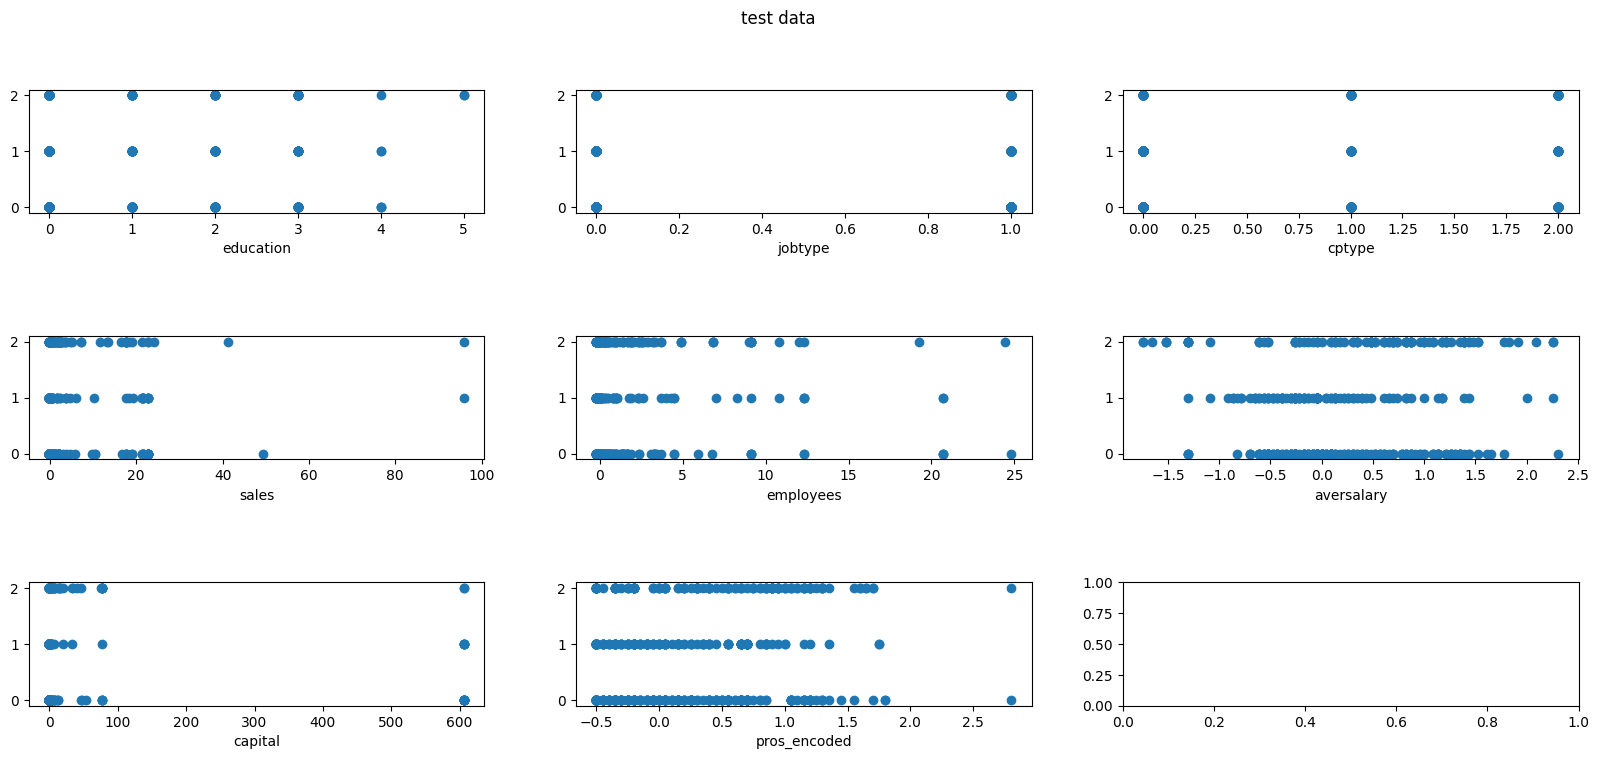

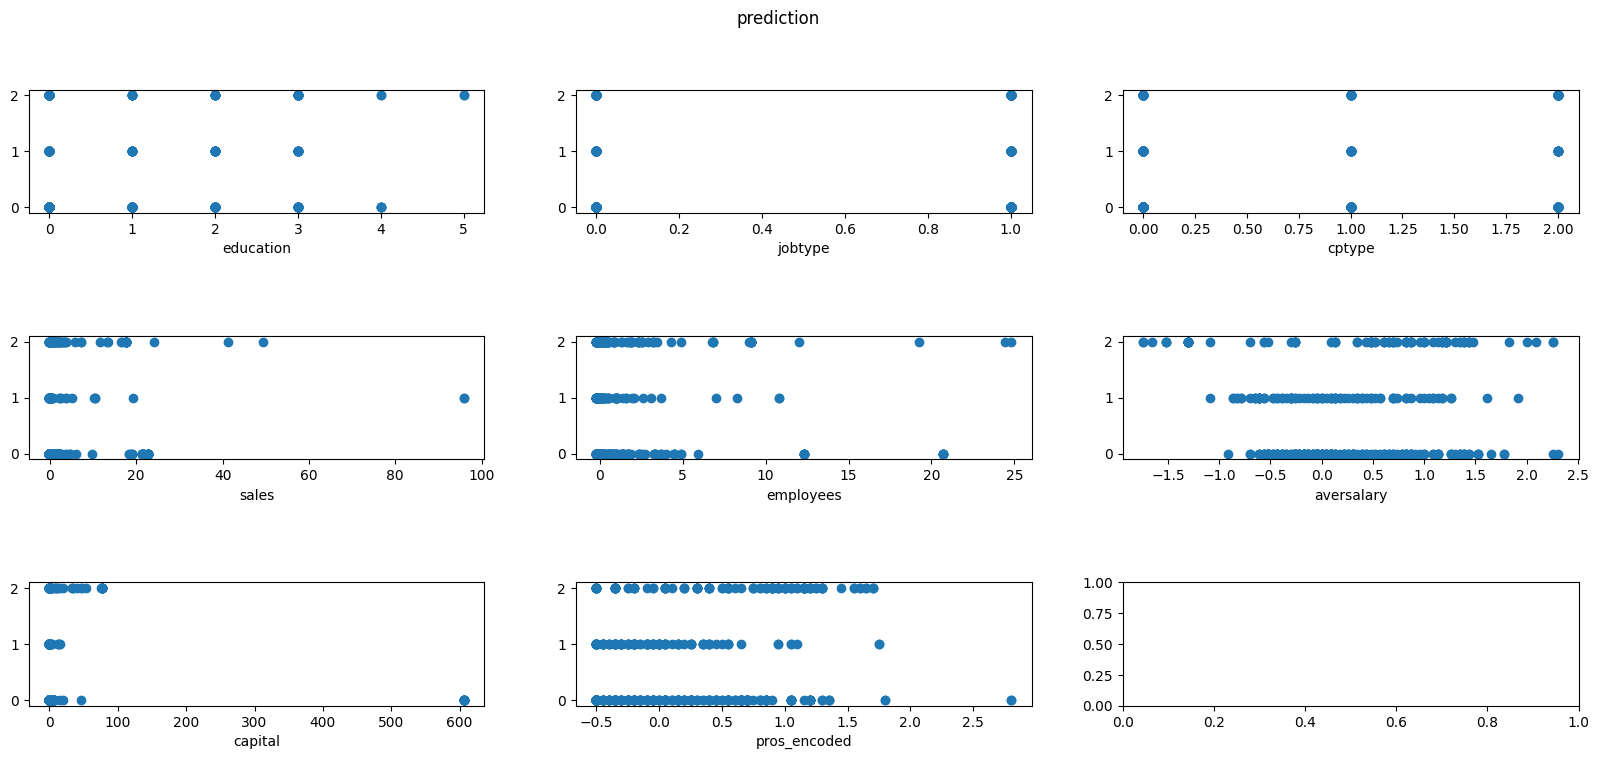

In [240]:
print("2 -> 수도권 : 서울, 인천, 세종, 경기")
print("1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산")
print("0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주")
region_counts = df['region'].value_counts()

total = df['region'].value_counts().sum()
for region, counts in enumerate(region_counts):
    print(f"{region} -> {counts} ({np.round(counts/total, 4)})")

X = df.iloc[:, 1:]
y = df['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747)

# Best Parameters :  {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.12}
# xgbClassifier_tuned = XGBClassifier(randSearch.best_params_)

xgbClassifier_tuned = XGBClassifier({'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.12})

xgbClassifier_tuned.fit(X_train, y_train)
y_pred = xgbClassifier_tuned.predict(X_test)

print("acc: ", accuracy_score(y_test, y_pred))

#### X_test - y_test 산점도 ####
features = df.columns[1:]

fig, axes = plt.subplots(nrows= 3, ncols=3, figsize=(20, 8))

fig.subplots_adjust(hspace=1, wspace=0.2)
for feature_idx in range(len(features)):
    axe_row = feature_idx // 3
    axe_col = feature_idx % 3
    axes[axe_row, axe_col].scatter(X_test[features[feature_idx]], y_test)
    axes[axe_row, axe_col].set_xlabel(features[feature_idx])
plt.suptitle("test data")
plt.show()

#### X_test - y_pred 산점도 ####
fig, axes = plt.subplots(nrows= 3, ncols=3, figsize=(20, 8))
fig.subplots_adjust(hspace=1, wspace=0.2)
for feature_idx in range(len(features)):
    axe_row = feature_idx // 3
    axe_col = feature_idx % 3
    axes[axe_row, axe_col].scatter(X_test[features[feature_idx]], y_pred)
    axes[axe_row, axe_col].set_xlabel(features[feature_idx])

plt.suptitle("prediction")
plt.show()

In [241]:
print("value_counts of y_test\n", y_test.value_counts())
print("value_counts of y_pred\n", np.bincount(y_pred))

value_counts of y_test
 region
0    292
1    175
2    136
Name: count, dtype: int64
value_counts of y_pred
 [360 120 123]


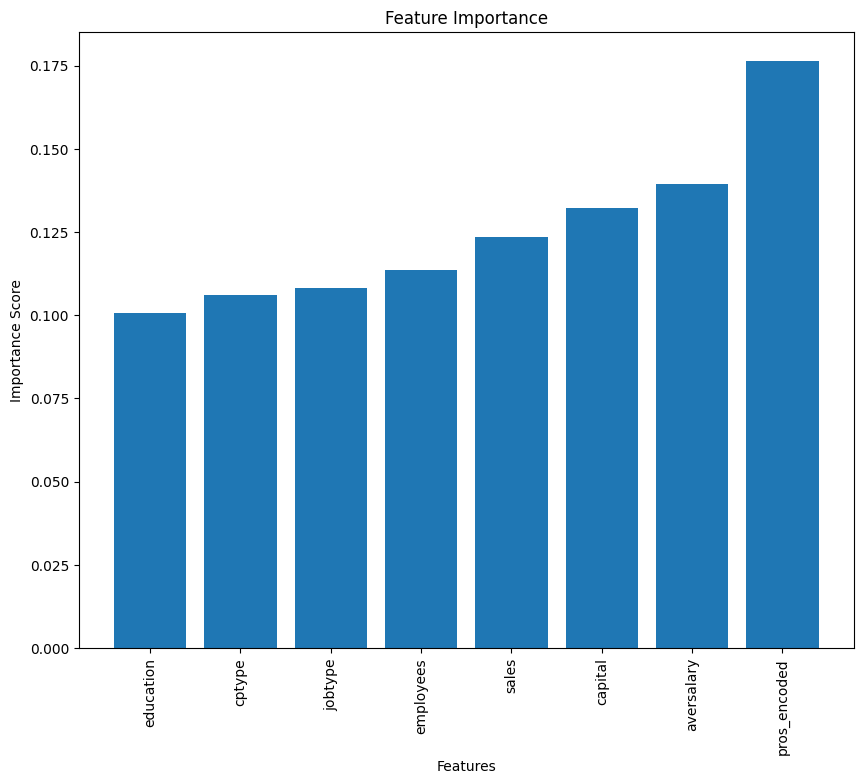

In [ ]:
feature_importance = xgbClassifier_tuned.feature_importances_
# 오름차순 정렬 시 인덱스
sorted_idx = np.argsort(feature_importance)

X = df.iloc[:, 1:]

plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx], rotation=90)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()


수집한 약 3000여개 행 데이터를 가지고 지도학습모델(xgboost사용) 을 생성하여 '구인 공고 모집 지역'을 예측해 보았다.

생성한 모델로 예측한 결과, 무작위 예측 시 정확도 약 0.3637 와, 무조건 class 0 으로 예측하는 모델 정확도 0.4725 비해 소폭 높은 테스트 정확도 약 0.5423 을 기록하였다.

따라서 그렇게 높은 정확도는 아니지만, 크롤링으로 수집한 데이터가 제한적이었던 점을 감안하고도 무작위 예측보다 약 20% 더 높은 정확도를 기록했음을 감안하여  
설정한 가설 중 첫 번째인  
##### < 1. 구인 공고 데이터로 지역 예측이 가능할 것이다 (지도학습). > 는 어느 정도는 맞는 것으로 판단하고자 한다.

## 가설 검정

Index(['region', 'education', 'jobtype', 'cptype', 'sales', 'employees',
       'aversalary', 'capital', 'pros_encoded'],
      dtype='object')
region
0    1424
1     876
2     715
Name: count, dtype: int64


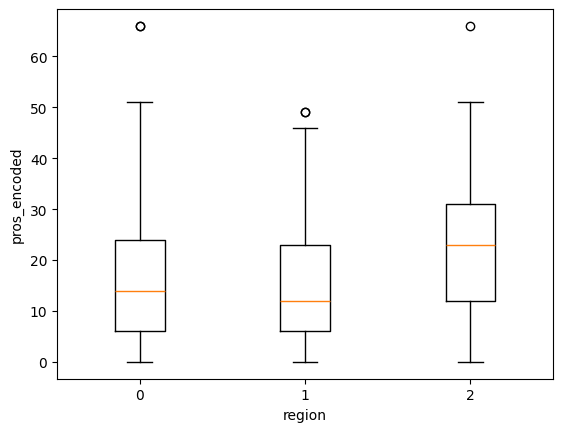

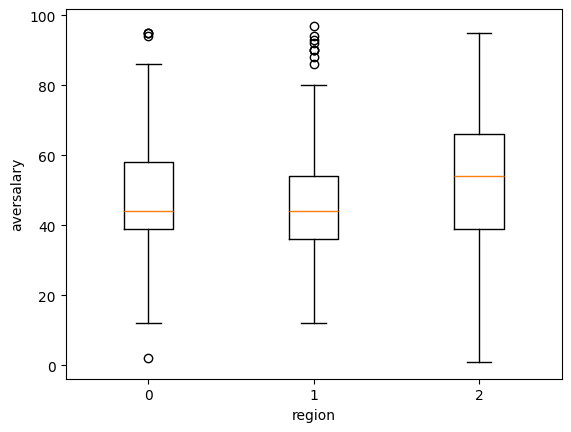

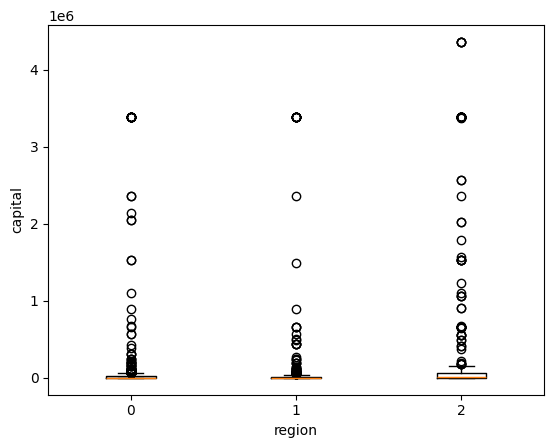

In [ ]:
df = pd.read_csv('data_beforeScaling.csv', encoding='utf-8-sig', index_col=0)

df_dropna = df.dropna()

print(df.columns)
print(df['region'].value_counts())

region_0 = df_dropna[df_dropna['region'] == 0]
region_1 = df_dropna[df_dropna['region'] == 1]
region_2 = df_dropna[df_dropna['region'] == 2]

# 튜닝된 XgboostClassifier 에서 feature importance 상위 3개. Numeric
features = ['pros_encoded', 'aversalary', 'capital']

for feature in features:
    plot_data = [region_0[feature], region_1[feature], region_2[feature]]
    ax = plt.boxplot(plot_data, labels=[0, 1, 2])
    plt.xlabel("region")
    plt.ylabel(feature)
    plt.show()

### 검정

튜닝된 XgboostClassifier 에서 feature importance 상위 3개 Numeric 피쳐 ['pros_encoded', 'aversalary', 'capital'] 에 대해 One-way ANOVA 검정 수행  
표본평균이 통계적으로 유의미한 수준으로 차이남을 확인  

정규성은 만족하지 않으나, bartlett's test 를 통해 등분산성 확인.

In [ ]:
from scipy import stats

In [ ]:
features = ['pros_encoded', 'aversalary', 'capital']

print("정규성 만족 확인")
# pvalue > 0.05 이상이면 정규성 만족
for feature in features:
    print(feature)
    print(stats.shapiro(region_0[feature]).pvalue)
    print(stats.shapiro(region_1[feature]).pvalue)
    print(stats.shapiro(region_2[feature]).pvalue)

# 정규성은 만족하지 않으나, 비모수 검정보다 모수 검정이 더 유효하다고 판단
# 중심 극한 정리에 의해 정규성을 따르지 않더라도 모수적 검정 가능하다는 글을 참고함.
# reference : https://blog.minitab.com/ko/adventures-in-statistics-2/choosing-between-a-nonparametric-test-and-a-parametric-test
# https://statisticsbyjim.com/hypothesis-testing/nonparametric-parametric-tests/

print("\n등분산성 확인 (bartlett's test)")
# 등분산성 확인
for feature in features:
    print(feature)
    # bartlett 검정에서 p-value 가 작다면 등분산성일 가능성이 낮다
    # ref. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html#scipy.stats.bartlett
    print(stats.bartlett(stats.shapiro(region_0[feature]), 
                       stats.shapiro(region_1[feature]), 
                       stats.shapiro(region_2[feature])).pvalue)

print("\none-way ANOVA")
for feature in features:
    print(feature)
    print(stats.f_oneway(region_0[feature], region_1[feature], region_2[feature]))

정규성 만족 확인
pros_encoded
2.0417284676573435e-15
6.11914401374466e-14
4.077762406006191e-06
aversalary
4.327476979636317e-11
7.007666815514323e-07
8.01951850755442e-12
capital
4.7615466119399145e-49
3.844996469191931e-39
2.600756162531475e-34

등분산성 확인 (bartlett's test)
pros_encoded
0.9989575089562657
aversalary
0.9995357888129095
capital
0.7613775291558502

one-way ANOVA
pros_encoded
F_onewayResult(statistic=54.41740370023299, pvalue=1.3002302415233098e-23)
aversalary
F_onewayResult(statistic=5.923315229931658, pvalue=0.002733589619109128)
capital
F_onewayResult(statistic=29.428691826038236, pvalue=2.767483257396838e-13)


In [ ]:
print(region_0.isna().sum())
print(region_1.isna().sum())
print(region_2.isna().sum())

print(len(region_0))
print(len(region_1))
print(len(region_2))

region          0
education       0
jobtype         0
cptype          0
sales           0
employees       0
aversalary      0
capital         0
pros_encoded    0
dtype: int64
region          0
education       0
jobtype         0
cptype          0
sales           0
employees       0
aversalary      0
capital         0
pros_encoded    0
dtype: int64
region          0
education       0
jobtype         0
cptype          0
sales           0
employees       0
aversalary      0
capital         0
pros_encoded    0
dtype: int64
780
440
432


### ANOVA test 후 사후 검정

<검정 결과>  
[pros_encoded]  

지역마다 통계적으로 유의미한 수준으로 차이난다.

[aversalary]  

(비수도권 광역시, 수도권) - 지방지역의 차이는 무의미하다. 비수도권 광역시 - 수도권 의 차이는 유의미하다.

[capital]  

지방 - 비수도권 광역시 차이는 크게 무의미하다. 수도권 - (비수도권 광역시, 지방) 의 차이는 크게 유의미하다.  

[종합]

'입사지원하면 좋은 이유(pros_encoded)' 부분은 지역마다 유의미한 차이가 존재.  

평균연봉에 대해서는 예상한 것과 달리 지방과 수도권의 차이가 가장 크게 나타나지 않았다. 단순히 각 그룹 통계량 상으로도 [수도권 평균연봉 > 지방 평균연봉 > 비수도권 광역시 평균 연봉] 의 관계를 보였다.  

회사 자본에 대해서는 수도권에 대기업이 집중되는 경향이 있다보니 해당 분석 결과가 나온 것으로 생각된다.  

In [ ]:
import scikit_posthocs as sp

print("### scheffe's test ###")

features = ['pros_encoded', 'aversalary', 'capital']

for feature in features:
    x = pd.DataFrame({'0':region_0[feature].reset_index(drop=True), 
                      '1':region_1[feature].reset_index(drop=True), 
                      '2':region_2[feature].reset_index(drop=True)})

    x = x.melt(var_name='region', value_name=feature)

    x = x.dropna() # 지역마다 표본 수 동일

    # scheffe's test
    print("\n",feature)
    print(sp.posthoc_scheffe(x, val_col=feature, group_col='region'))

### scheffe's test ###

 pros_encoded
              0             1             2
0  1.000000e+00  1.517594e-02  1.938339e-15
1  1.517594e-02  1.000000e+00  1.842321e-21
2  1.938339e-15  1.842321e-21  1.000000e+00

 aversalary
          0         1         2
0  1.000000  0.197034  0.112865
1  0.197034  1.000000  0.002768
2  0.112865  0.002768  1.000000

 capital
              0             1             2
0  1.000000e+00  9.450213e-01  4.857861e-12
1  9.450213e-01  1.000000e+00  7.757975e-09
2  4.857861e-12  7.757975e-09  1.000000e+00


In [ ]:
print(region_0['aversalary'].mean())
print(region_1['aversalary'].mean())
print(region_2['aversalary'].mean())

47.787179487179486
45.925
49.958333333333336


<한계점 분석>  
수집한 데이터의 품질이 떨어져서 문제의 본질인 일자리의 '질적 평가'를 원하는 수준만큼 정확하게 내리지 못하였다.

구인 공고에서 가장 중요하다고 생각하는 연봉정보는 대부분 '회사 내규' 혹은 간혹 있더라도 이미지 내에 표시되어 있어 크롤랑하여 사용하지 못하였다. 회사 재정정보는 회사마다 최신화된 정보가 아닌 경우가 대부분이었으며, 이러한 이유로 인해 구인 공고 데이터를 통해 해당 일자리가 질적으로 우수한지 정확하게 평가하지 못하였다고 생각하고 가설도 검증에 실패할 것으로 예상하였다. 하지만 그럼에도 기대 이상의 분석 결과를 얻어 만족한다.